<a href="https://colab.research.google.com/github/anamilanezi/py-practices/blob/main/PubMedScraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align='center'> 🔎 PubMed Crawler </h1>

## 🧰 Introdução

A base de dados PubMed contém mais de 35 milhões de citações e resumos da literatura biomédica, incluindo revistas e livros, oferecendo uma plataforma gratuita para a busca e localização dessas produções científicas. 

Pensando nisso, este projeto desenvolvido em Python tem como objetivo criar uma ferramenta que faça a busca utilizando determinados termos de interesse e ao final produz uma planilha contendo os resultados da busca incluindo informações relevantes como título do artigo, resumo, autores, dentre outras.

Para isso, serão utilizadas as seguintes bibliotecas:
* `requests` para solicitações e requisições http
* `BeautifulSoup` para a extração de dados das páginas HTML
* `urllib parse` para transformar as informações em formato adequado nas requisições
* `pandas` para estruturação de dados e exportação de planilhas
* `re` para busca textual

A busca avançada no site pode ser realizada através de diversos campos e é efetuada com uma requisição do tipo GET que insere os termos e condições da busca na URL, como mostra a imagem.

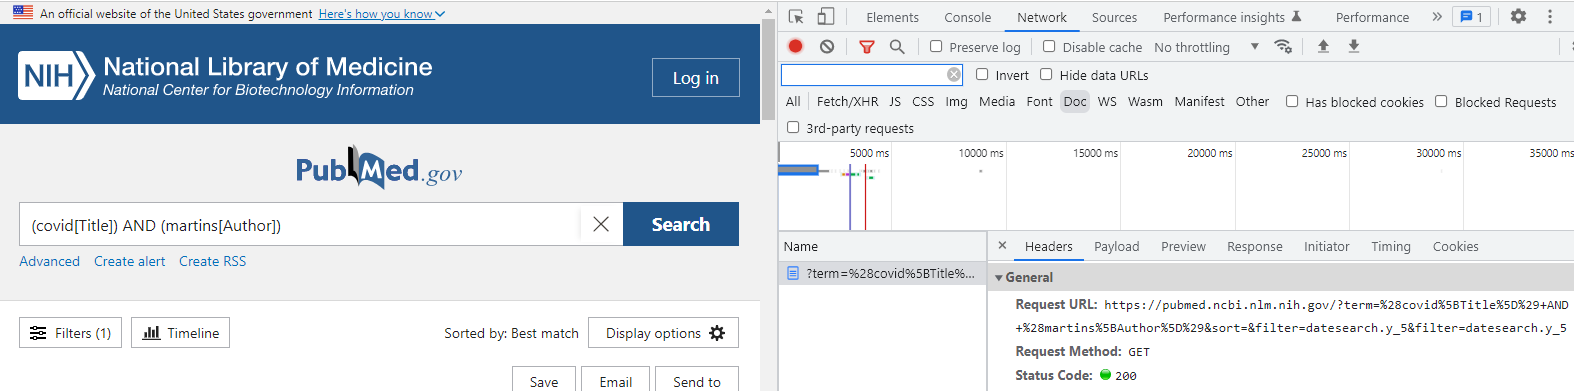

Sendo assim, para este projeto foram determinados alguns critérios para encontrar as informações, buscando apenas publicações dos últimos 5 anos utilizando os seguintes campos de busca:

* **Busca geral** (`all`): esse campo faz uma busca geral sem restringir os termos inseridos a qualquer campo específico da busca, retornando qualquer publicação em que o termo apareça.
* **Autor** (`[Author]`): busca por publicações onde algum dos autores corresponda ao termo inserido.
* **Primeiro autor** (`[Author - First]`): busca por publicações onde o primeiro autor corresponda ao termo inserido.
* **Linguagem** (`[Language]`): busca publicações na linguagem especificada (deve ser informada em inglês)
* **Título** (`[Title]`): busca por publicações que contenha o termo no título.
* **Título/Resumo** (`[Title/Abstract]`): busca por publicações que contenha o termo no título ou resumo da publicação.

Todas essas informações são inseridas como **argumentos de palavras-chave**, ou seja , quando passados ​​para a função, são identificadps ​​pelos nomes de parâmetros específicos.

Vale destacar que o site oferece diversos campos de busca, que podem ser inseridos ao projeto utilizando o mesmo padrão dos outros termos, ou seja, inserir o nome do campo como está no site como uma chave no dicionário associado a um valor correspondente ao termo de busca.

Exemplo de como inserir novos campos de busca: 
```python
  dict = {
      'all': all,
      '[Author]': author,
      '[Author - First]': authorfirst,
      '[Book]': book,
      '[Journal]': journal,
      '[Language]': language,
      '[Title]': title,
      '[Title/Abstract]': titleabstract,
      '[Editor]': editor,
      '[Filter]': filter,
    }
```


## 💻 Códigos

In [ ]:
# Importação de bibliotecas e definição de header para requisições

import re
import sys
import urllib
import requests
import pandas as pd
from urllib import parse
from bs4 import BeautifulSoup 

Com base nas informações de interesse que foram selecionadas, duas funções são responsáveis por consolidar os dados e criar a url que retorna os resultados da busca:
* `search_term`: recebe os termos da busca e retorna um dicionário. Os termos são informados como argumentos na chamada da função. Note que nenhum dos termos é obrigatório, já que todos possuem um valor `None` padrão, que será ignorado caso a informação não for inserida.

* `get_url`: recebe o dicionário da função anterior e retorna a URL que contém os resultados da busca.

In [ ]:
# Criar um dicionário com os critérios de busca

def search_term(all=None,
                author=None, 
                authorfirst=None,
                book=None,
                journal=None,
                language=None,
                title=None,
                titleabstract=None
                ):
  '''Recebe os termos de consulta e retorna um dicionário que depois será decodificado'''
  
  dict = {
      'all': all,
      '[Author]': author,
      '[Author - First]': authorfirst,
      '[Book]': book,
      '[Journal]': journal,
      '[Language]': language,
      '[Title]': title,
      '[Title/Abstract]': titleabstract,
  }

  if dict['all'] is None:
    term = ''
  else:
    term = f'{all}'

  for key, value in dict.items():
    if value is not None and key != 'all':
      if term == '':
        term += f'{value}{key}'
      else:
        term += f' AND {value}{key}'

  search_term = {
  'term': term,
  'filter': 'datesearch.y_5',
  'format': 'abstract'
}
  return search_term


# A busca é feita através da URL, por isso utilizamos o dicionário que é codificado na URL utilizando a função urllib.parse.urlencode(dict)

def get_url(dict):

  search = urllib.parse.urlencode(dict)
  url = f'https://pubmed.ncbi.nlm.nih.gov/?{search}'

  return url

Com essas duas funções, podemos verificar o número de páginas contendo resultados para os termos inseridos utilizando `BeautifulSoup`, assim como percorrer todas as páginas de resultados, selecionando as informações de interesse, e por fim e preencher um dataframe utilizando `pandas` de acordo com esses resultados. O fluxo de execução e as funções envolvidas são as seguintes:

* `frame_results`: a função que determina todo o funcionamento do programa, recebe o dicionário com os termos da busca já consolidados.
  * `get_url`: Transforma o dicionário na url para requisição
  * `get_n_pages`: A função recebe um objeto BeautifulSoup que representa a página HTML obtida na requisição como uma estrutura de dados aninhada, e retorna o número de páginas contendo resultados para os termos da busca.
  * `list_urls`: A função recebe a url que foi criada por `get_url` e o número de páginas contendo resultados, e retorna uma lista com as urls dos resultados. Essa lista é percorrida e cada url chama a função seguinte.
  * `results_data`: A função recebe a url exibindo os resultados da pesquisa, faz a inspeção das informações de interesse, chamando as funções responsáveis, e cria um DataFrame com os resultados. 

Ao final, `frame_results` concatena todos os DataFrames gerados.

In [ ]:

def frame_results(search_term):
  
  url = get_url(search_term)
  response = requests.get(url)
  
  soup = BeautifulSoup(response.content, 'html.parser')

  n = get_n_pages(soup)

  if n is not None:
    urls = list_urls(n, url)

    dfs = []

    for url in urls:

      df = results_data(url)

      dfs.append(df)
    
    df = pd.concat(dfs).reset_index(drop=True)
    print(f'Artigos encontrados: {len(df.index)}')

    return df

  else:
    print("Nenhum resultado encontrado.")


# Após a requisição utilizando a primeira URL de busca criada, é possível obter o número de páginas que apresentam resultados para a busca

def get_n_pages(soup):

  pages = soup.find('label', class_="of-total-pages")

  if pages is not None:
    return re.findall(r'\b\d+\b', pages.text)[0]
  # try:
  #   n = re.findall(r'\b\d+\b', pages.text)[0]

  # except AttributeError:
  #   print("Nenhum resultado foi encontrado para essa busca.")
  
  # else: 
  #   return n


# Através do número de páginas, criamos uma lista de URLs para cada página, que consiste na junção da primeira URL de busca criada com o número da página

def list_urls(n_pages, url):
  urls = []
  
  for i in range (1, int(n_pages) + 1):
    u = f'{url}&page={str(i)}'
    urls.append(u)

  return urls



def results_data(url):
  
  response = requests.get(url)

  soup = BeautifulSoup(response.content, 'html.parser')

  # Encontrar os resultados da página
  results = soup.find('div', class_="search-results").find_all('div', class_='results-article')

  dict = {
          'Title' : get_titles(results),
          'Authors' : get_authors(results),
          'Abstract' :  get_abstracts(results),
          'Magazine' : get_magazines(results),
          'Date' : get_pub_dates(results),
          'DOI' : get_dois(results),
          'Num Citations' : get_n_citations(results),
          'URL Citations' : get_citations(results),
          }

  return pd.DataFrame(dict)


As informações de interesse são individualmente extraídas e formatadas, cada uma utilizando os elementos HTML que identificam aquela seção da página.

In [ ]:
def get_titles(results):

  return [r.find_next('h1').text.strip() for r in results]



def get_authors(results):

  authors_list = [r.find_all('a', class_='full-name') for r in results]

  authors_text_list = []

  for authors in authors_list:
    authors_text = []

    for author in authors:
      if author.text.strip() not in authors_text:
        authors_text.append(author.text.strip())

    authors_text_list.append('; '.join(authors_text))

  return authors_text_list


def get_abstracts(results):

  abstracts = []

  for r in results:
    abstract = r.find('div', class_='abstract-content selected')
    if abstract is not None:
      abstracts.append(abstract.text.strip())
    else:
      abstracts.append(None)

  return abstracts



def get_magazines(results):

  mags = []

  for r in results:
    mag = r.find('button', class_='journal-actions-trigger trigger')
    if mag is not None:
      mags.append(mag.text.strip())
    else:
      mags.append(None)

  return mags

  # return [r.find('button', class_='journal-actions-trigger trigger').text.strip() for r in results]


def get_pub_dates(results):

  dates = []

  for r in results:
    date = r.find('span', class_='cit')
    if date is not None:
      dates.append(date.text.strip().split(';')[0])
    else:
      dates.append(None)

  return dates
  # return [r.find('span', class_='cit').text.strip().split(';')[0] for r in results]


def get_dois(results):

  dois = []

  for r in results:
    doi = r.find('span', class_='identifier doi')
    if doi is not None:
      dois.append(doi.find('a', class_='id-link').get("href"))
    else:
      dois.append(None)

  return dois
  # return [r.find('span', class_='identifier doi').find('a', class_='id-link').get("href") for r in results]


def get_n_citations(results):

  n_citations = []

  for r in results:
    citations = r.find('li', class_='citedby-count')
    if citations is not None:
      n = citations.text.strip().replace('\n', '').split(' ')[2]
      n_citations.append(n)
    else:
      n_citations.append(None)
  
  return n_citations


def get_citations(results):
  url_citations = []

  for r in results:
    citations = r.find('li', class_='citedby-count')
    if citations is not None:
      url = f"https://pubmed.ncbi.nlm.nih.gov{citations.find('a').get('href')}"
      url_citations.append(url)
    else:
      url_citations.append(None)
  
  return url_citations



## 📝 Exemplos

Encontrar artigos que contenham os termos "silva deep learning rna" em quaisquer campos:

In [ ]:
search = search_term(all='silva deep learning rna')
df = frame_results(search)

# Exibir os 10 primeiros resultados
df.head(10)

Artigos encontrados: 3


,Title,Authors,Abstract,Magazine,Date,DOI,Num Citations,URL Citations
0,RNAmining: A machine learning stand-alone and ...,Thaís A R Ramos; Nilbson R O Galindo; Raúl Ari...,Non-coding RNAs (ncRNAs) are important players...,F1000Res,2021 Apr 26,https://doi.org/10.12688/f1000research.52350.2,1,https://pubmed.ncbi.nlm.nih.gov/34164114/#citedby
1,Convolutional Neural Network Applied to SARS-C...,Gabriel B M Câmara; Maria G F Coutinho; Lucile...,"COVID-19, the illness caused by the severe acu...",Sensors (Basel),2022 Jul 31,https://doi.org/10.3390/s22155730,None,None
2,Splicing impact of deep exonic missense varian...,Eugénie Dionnet; Aurélia Defour; Nathalie Da S...,Improving the accuracy of variant interpretati...,Hum Mutat,2020 Oct,https://doi.org/10.1002/humu.24083,2,https://pubmed.ncbi.nlm.nih.gov/32668095/#citedby


Encontrar artigos contendo "molecular" no título com "Borba" no primeiro autor:

In [ ]:
search = search_term(authorfirst='Borba', title="molecular")
df = frame_results(search)

# Exibir os 10 primeiros resultados
df.head(10)

Artigos encontrados: 4


,Title,Authors,Abstract,Magazine,Date,DOI,Num Citations,URL Citations
0,Molecular discrimination of Ancistrus lineages...,Rafael Splendore de Borba; Sandra Mariotto; Li...,Although several species of Ancistrus have bee...,Mitochondrial DNA A DNA Mapp Seq Anal,2019 May,https://doi.org/10.1080/24701394.2019.1597071,1,https://pubmed.ncbi.nlm.nih.gov/30983442/#citedby
1,Evaluation of BOX-PCR and REP-PCR as Molecular...,Marcela Proença Borba; Ana Elisa Ballarini; Jo...,Molecular studies led to the resurgence of nat...,Curr Microbiol,2020 Nov,https://doi.org/10.1007/s00284-020-02199-6,1,https://pubmed.ncbi.nlm.nih.gov/32939638/#citedby
2,Chemoproteomic identification of molecular tar...,Joyce Villa Verde Bastos Borba; Sinji Borges F...,Paracoccidioidomycosis (PCM) is a neglected hu...,PLoS One,2018 Aug 27,https://doi.org/10.1371/journal.pone.0201948,5,https://pubmed.ncbi.nlm.nih.gov/30148835/#citedby
3,The intricate molecular identification of Stre...,Marcela Proença Borba; Ana Paula da Silva Ferr...,Despite the worldwide use of 16S rRNA to ident...,Arch Microbiol,2022 Jul 13,https://doi.org/10.1007/s00203-022-03093-4,None,None


---

Encontrar artigos disponíveis em inglês que contenham "mocribiology artificial intelligence" no título.

In [ ]:
search = search_term(language='english', title='microbiology artificial intelligence')
df = frame_results(search)
print(f'Artigos encontrados: {len(df.index)}')
df.head(10)

Artigos encontrados: 138


,Title,Authors,Abstract,Magazine,Date,DOI,Num Citations,URL Citations
0,Artificial intelligence in the diagnosis of CO...,Shigao Huang; Jie Yang; Simon Fong; Qi Zhao,Artificial intelligence (AI) is being used to ...,Int J Biol Sci,2021 Apr 10,https://doi.org/10.7150/ijbs.58855,17,https://pubmed.ncbi.nlm.nih.gov/33907522/#citedby
1,Precision medicine in the era of artificial in...,Murugan Subramanian; Anne Wojtusciszyn; Lucie ...,Aberrant metabolism is the root cause of sever...,J Transl Med,2020 Dec 9,https://doi.org/10.1186/s12967-020-02658-5,20,https://pubmed.ncbi.nlm.nih.gov/33298113/#citedby
2,Application of artificial intelligence and mac...,Hao Lv; Lei Shi; Joshua William Berkenpas; Fu-...,The global pandemic of coronavirus disease 201...,Brief Bioinform,2021 Nov 5,https://doi.org/10.1093/bib/bbab320,17,https://pubmed.ncbi.nlm.nih.gov/34410360/#citedby
3,Artificial Intelligence in the Fight Against C...,Alaa Abd-Alrazaq; Mohannad Alajlani; Dari Alhu...,Background:\n \n \n In Decemb...,J Med Internet Res,2020 Dec 15,https://doi.org/10.2196/20756,30,https://pubmed.ncbi.nlm.nih.gov/33284779/#citedby
4,Bibliometric analysis of artificial intelligen...,Dongyu Xu; Bing Liu; Jian Wang; Zhichang Zhang,Background: In the biotechnology and applied m...,Front Bioeng Biotechnol,2022 Oct 7,https://doi.org/10.3389/fbioe.2022.998298,None,None
5,Editorial: Artificial Intelligence in Environm...,Mohammad-Hossein Sarrafzadeh; Seyed Soheil Man...,None,Front Microbiol,2022 Jun 13,https://doi.org/10.3389/fmicb.2022.944242,None,None
6,Levofloxacin Pharmacokinetics/Pharmacodynamics...,Devyani Deshpande; Jotam G Pasipanodya; Stella...,Background:\n \n \n Levofloxa...,Clin Infect Dis,2018 Nov 28,https://doi.org/10.1093/cid/ciy611,26,https://pubmed.ncbi.nlm.nih.gov/30496461/#citedby
7,Artificial-intelligence-driven discovery of pr...,Heewon Chung; Yunju Jo; Dongryeol Ryu; Changwo...,Background:\n \n \n Sarcopeni...,J Cachexia Sarcopenia Muscle,2021 Dec,https://doi.org/10.1002/jcsm.12840,2,https://pubmed.ncbi.nlm.nih.gov/34704369/#citedby
8,Integrating Artificial Intelligence for Clinic...,Taran Rishit Undru; Utkarsha Uday; Jyothi Tadi...,Introduction: The development of medical artif...,Maedica (Bucur),2022 Jun,https://doi.org/10.26574/maedica.2022.17.2.420,None,None
9,Artificial intelligence and metagenomics in in...,Yufeng Lin; Guoping Wang; Jun Yu; Joseph J Y Sung,Gut microbiota has been shown to associate wit...,J Gastroenterol Hepatol,2021 Apr,https://doi.org/10.1111/jgh.15501,None,None




---

Encontrar artigos disponíveis em português com um dos autores contendo "Hallal"

In [ ]:
search = search_term(language='portuguese', author='hallal')
df = frame_results(search)
df.head(10)

Artigos encontrados: 16


,Title,Authors,Abstract,Magazine,Date,DOI,Num Citations,URL Citations
0,Resistance and Resilience in the throes of a P...,Pedro Curi Hallal,None,Cien Saude Colet,2020 Sep,https://doi.org/10.1590/1413-81232020259.20312020,None,None
1,Chronic non-communicable diseases and COVID-19...,Marilia Arndt Mesenburg; Pedro Curi Hallal; An...,Objective:\n \n \n Describing...,Rev Saude Publica,2021 Jun 2,https://doi.org/10.11606/s1518-8787.2021055003673,5,https://pubmed.ncbi.nlm.nih.gov/34105606/#citedby
2,[What is urgent and necessary to inform polici...,Mauricio Lima Barreto; Aluisio Jardim Dornella...,None,Rev Bras Epidemiol,2020 Apr 22,https://doi.org/10.1590/1980-549720200032,13,https://pubmed.ncbi.nlm.nih.gov/32321004/#citedby
3,[Mask use during the COVID-19 pandemic in Braz...,Nadège Jacques; Mariângela Freitas da Silveira...,"By March 3, 2022, the COVID-19 pandemic has ca...",Cad Saude Publica,2022 Jul 15,https://doi.org/10.1590/0102-311xpt271921,None,None
4,[Age structure and mortality due to COVID-19],Pedro Curi Hallal; Fernando P Hartwig,None,Cien Saude Colet,2020 Sep,https://doi.org/10.1590/1413-81232020259.21182020,1,https://pubmed.ncbi.nlm.nih.gov/32876272/#citedby
5,Consumption of fruits and vegetables and assoc...,Bianca Bittencourt de Souza; Francieli Cembran...,The aim of this study was to estimate the asso...,Cien Saude Colet,2019 Apr,https://doi.org/10.1590/1413-81232018244.03782017,None,None
6,Physical activity during the COVID-19 pandemic...,Inácio Crochemore-Silva; Alan Goularte Knuth; ...,This study aimed to describe leisure-time phys...,Cien Saude Colet,2020 Nov,https://doi.org/10.1590/1413-812320202511.2907...,5,https://pubmed.ncbi.nlm.nih.gov/33175034/#citedby
7,Factors associated with the use of waterpipe a...,Deborah Carvalho Malta; Ana Luiza Curi Hallal;...,Objective:\n \n \n To identif...,Rev Bras Epidemiol,2018 Nov 29,https://doi.org/10.1590/1980-549720180006.supl.1,2,https://pubmed.ncbi.nlm.nih.gov/30517457/#citedby
8,Prevalence of symptoms of COVID-19 in the stat...,Marilia Arndt Mesenburg; Pedro Curi Hallal; An...,Objective:\n \n \n To evaluat...,Rev Saude Publica,2021 Nov 22,https://doi.org/10.11606/s1518-8787.2021055004030,None,None
9,Influenza vaccination in older adults during t...,Ana Maria Baptista Menezes; Pedro Curi Hallal;...,Routine immunization during pandemics can be h...,Cien Saude Colet,2021 Aug,https://doi.org/10.1590/1413-81232021268.09382021,1,https://pubmed.ncbi.nlm.nih.gov/34378687/#citedby


In [ ]:
# Salvar a planilha como Excel
# df.to_excel('results.xlsx', index=False)

Melhorias a serem implementadas:
* Transformar a coluna de data em `datetime` (utilizar somente mês e ano para consolidar as informações)
